In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install ../input/textstat-070/wheelhouse/Pyphen-0.10.0-py3-none-any.whl
!pip install ../input/textstat-070/wheelhouse/textstat-0.7.0-py3-none-any.whl

Processing /kaggle/input/textstat-070/wheelhouse/Pyphen-0.10.0-py3-none-any.whl
Processing /kaggle/input/textstat-070/wheelhouse/textstat-0.7.0-py3-none-any.whl


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import spacy
import time
import re
import nltk
import textstat
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from tqdm.notebook import tqdm

nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [4]:
train_df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
test_df = pd.read_csv("../input/commonlitreadabilityprize/test.csv")

In [5]:
print("Training Data Points")
train_df.head()

Training Data Points


,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [6]:
print("Test Data points")
test_df.head()

Test Data points


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [7]:
print(f"Train data shape {train_df.shape}")
print(f"Train data unique values:-\n{train_df.nunique()}")

Train data shape (2834, 6)
Train data unique values:-
id                2834
url_legal          667
license             15
excerpt           2834
target            2834
standard_error    2834
dtype: int64


Text(0, 0.5, '# of missing values')

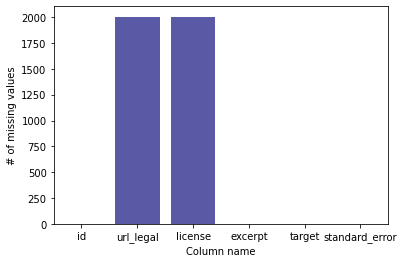

In [8]:
sns.barplot(x = train_df.isna().sum().index,
            y = train_df.isna().sum().values,
            color='blue',saturation=0.3)
plt.xlabel("Column name")
plt.ylabel("# of missing values")

In [9]:
excerpt1 = train_df['excerpt'].min()
print("Before preprocessing: ")
print(excerpt1)

e = re.sub("[^a-zA-Z]", " ", excerpt1)
e = e.lower()
        
e = nltk.word_tokenize(e)
        
e = [word for word in e if not word in set(stopwords.words("english"))]
        
lemma = nltk.WordNetLemmatizer()
e = [lemma.lemmatize(word) for word in e]
e=" ".join(e)
print("After preprocessing: ")
print(e)

Before preprocessing: 
"'Morning, Jeeves," I said.
"Good morning, sir," said Jeeves. He put the good old cup of tea softly on the table by my bed, and I took a refreshing sip. Just right, as usual. Not too hot, not too sweet, not too weak, not too strong, not too much milk, and not a drop spilled in the saucer. A most amazing cove, Jeeves. So dashed competent in every respect. I've said it before, and I'll say it again. I mean to say, take just one small instance. Every other valet I've ever had used to barge into my room in the morning while I was still asleep, causing much misery: but Jeeves seems to know when I'm awake by a sort of telepathy. He always floats in with the cup exactly two minutes after I come to life. Makes a deuce of a lot of difference to a fellow's day.
"How's the weather, Jeeves?" 
"Exceptionally clement, sir."
"Anything in the papers?"
"Some slight friction threatening in the Balkans, sir. Otherwise, nothing."
After preprocessing: 
morning jeeves said good mornin

In [10]:
def preprocess(data):
    excerpt_processed = []
    for i in tqdm(data['excerpt']):
        
        i = re.sub("[^a-zA-Z]"," ",i)
        i = i.lower()
        i = nltk.word_tokenize(i)
        i = [word for word in i if not word in set(stopwords.words("english"))]
        
        lemma = nltk.WordNetLemmatizer()
        i = [lemma.lemmatize(word) for word in i]
        i=" ".join(i)
        excerpt_processed.append(i)
    return excerpt_processed
        

In [11]:
train_df["excerpt_preprocessed"] = preprocess(train_df)
test_df["excerpt_preprocessed"] = preprocess(test_df)

  0%|          | 0/2834 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

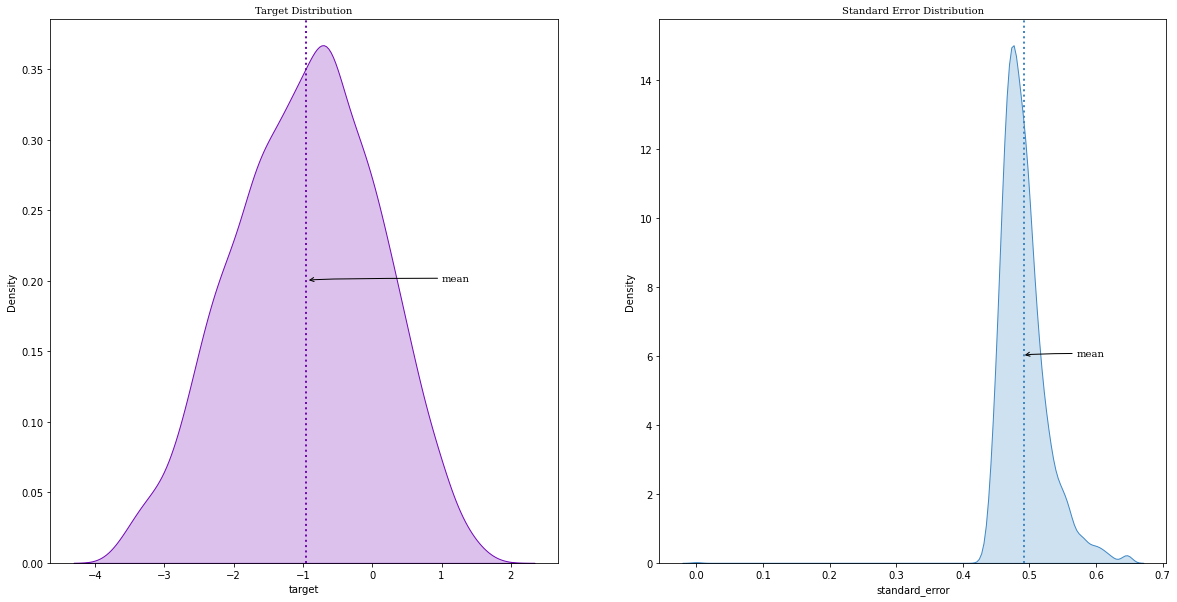

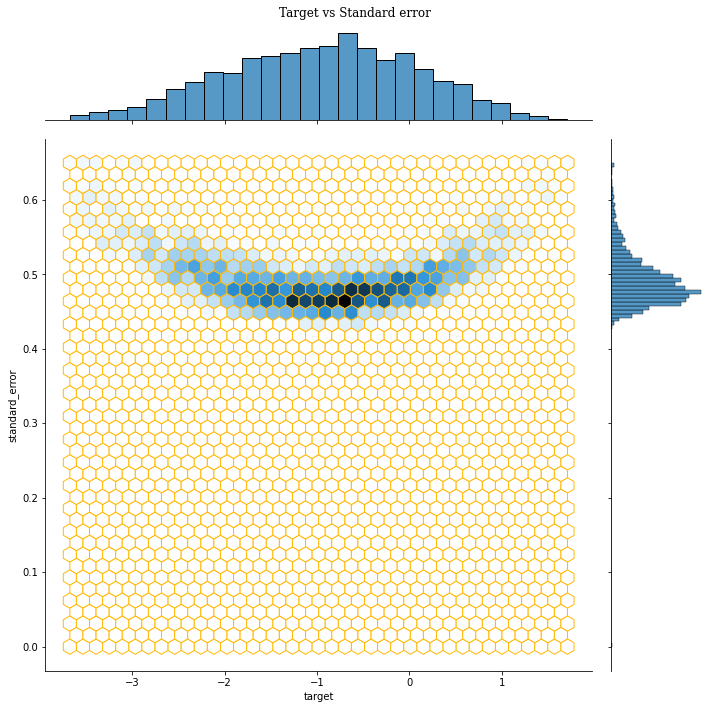

In [12]:
palette = ["#7209B7","#3F88C5","#136F63","#F72585","#FFBA08"]
fig, ax = plt.subplots(1,2,figsize=(20,10))
sns.kdeplot(train_df['target'], color=palette[0], shade=True,ax=ax[0])
sns.kdeplot(train_df['standard_error'], color=palette[1], shade=True,ax=ax[1])
ax[0].axvline(train_df['target'].mean(), color=palette[0],linestyle=':', linewidth=2)
ax[1].axvline(train_df['standard_error'].mean(), color=palette[1],linestyle=':', linewidth=2)
ax[0].set_title("Target Distribution",font="Serif")
ax[1].set_title("Standard Error Distribution",font="Serif")
ax[0].annotate('mean', xy=(-0.3* np.pi, 0.2), xytext=(1, 0.2), font='Serif',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));
ax[1].annotate('mean', xy=(0.49, 6), xytext=(0.57, 6), font='Serif',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));
plt.show()

sns.jointplot(x=train_df['target'], y=train_df['standard_error'], kind='hex',height=10,edgecolor=palette[4])
plt.suptitle("Target vs Standard error ",font="Serif")
plt.subplots_adjust(top=0.95)
plt.show()

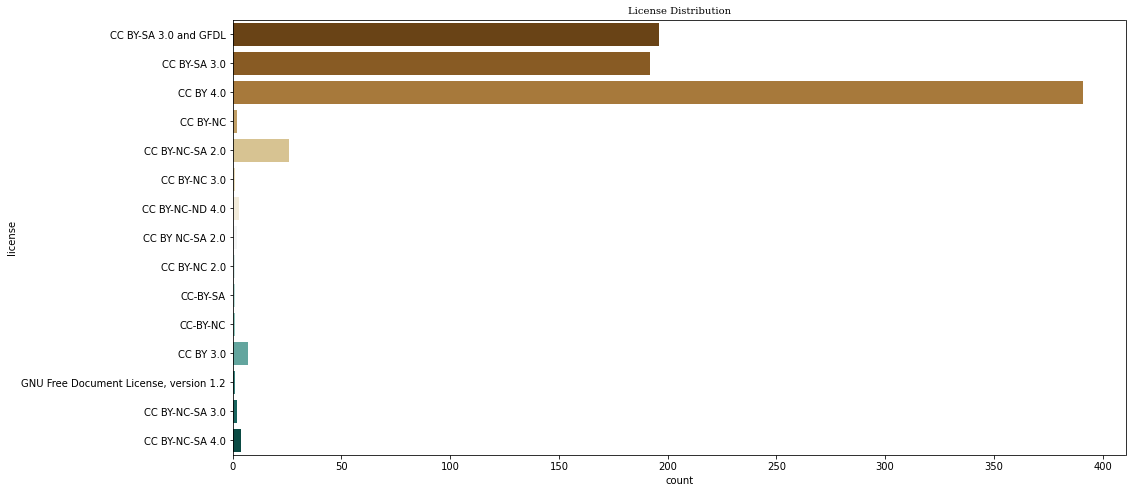

In [13]:
plt.figure(figsize=(16, 8))
sns.countplot(y="license",data=train_df,palette="BrBG",linewidth=3)
plt.title("License Distribution",font="Serif")
plt.show()

In [14]:
def get_top_n_words(corpus, n=None):
    vec = CV().fit(corpus)
    bag_of_words = vec.transform(corpus)
    word_count = bag_of_words.sum(axis=0)
    words_freq = [(word, word_count[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CV(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_trigram(corpus, n=None):
    vec = CV(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [15]:
def plot_bt(x,w,p):
    common_words = x(train_df['excerpt_preprocessed'], 20)
    common_words_df = pd.DataFrame (common_words,columns=['word','freq'])

    plt.figure(figsize=(16,8))
    sns.barplot(x='freq', y='word', data=common_words_df,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette(p,20))
    plt.title("Top 20 "+ w,font='Serif')
    plt.xlabel("Frequency", fontsize=14)
    plt.yticks(fontsize=13)
    plt.xticks(rotation=45, fontsize=13)
    plt.ylabel("");
    return common_words_df

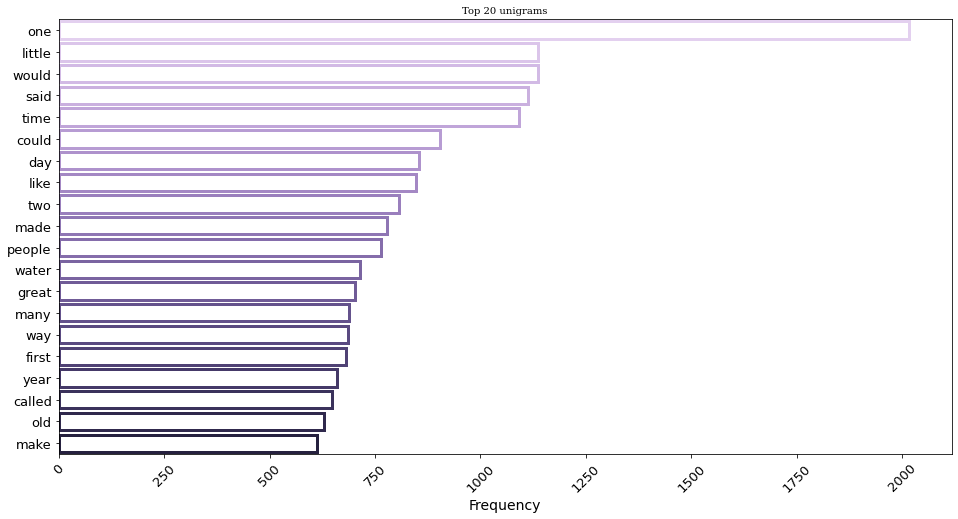

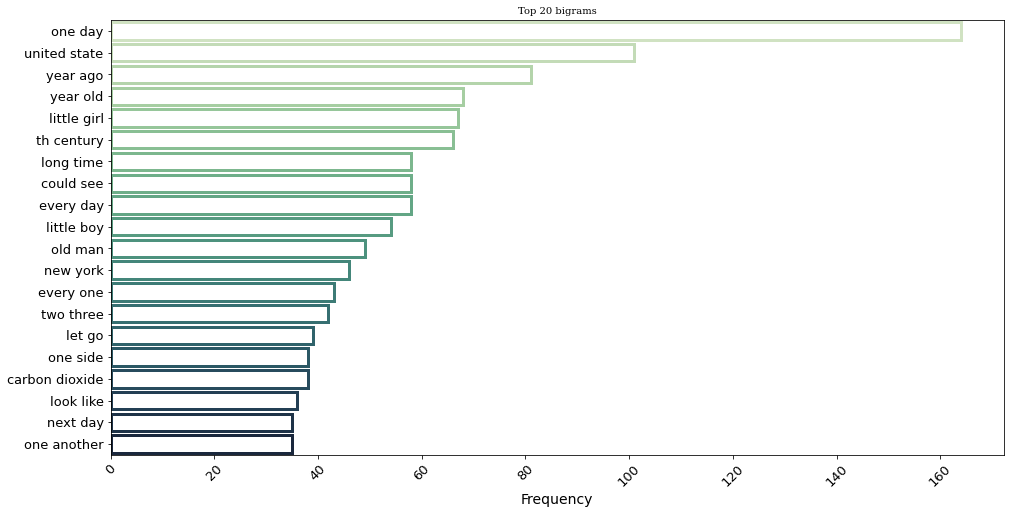

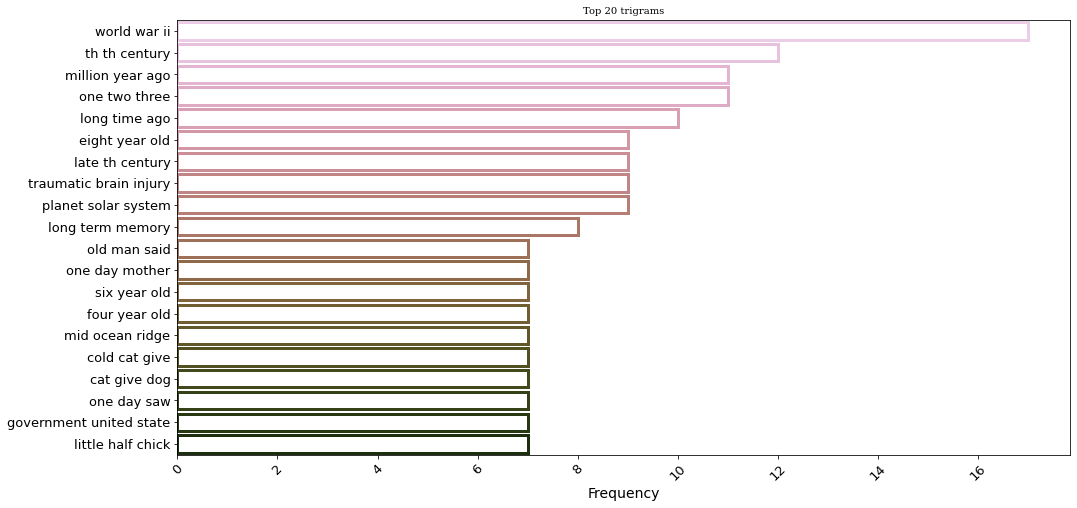

In [16]:
common_words = get_top_n_words(train_df['excerpt_preprocessed'], 20)
common_words_df1 = pd.DataFrame(common_words,columns=['word','freq'])
plt.figure(figsize=(16, 8))
ax = sns.barplot(x='freq', y='word', data=common_words_df1,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("ch:start=3, rot=.1",20))

plt.title("Top 20 unigrams",font='Serif')
plt.xlabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");

common_words_df2 = plot_bt(get_top_n_bigram,"bigrams","ch:rot=-.5")
common_words_df3 = plot_bt(get_top_n_trigram,"trigrams","ch:start=-1, rot=-.6")

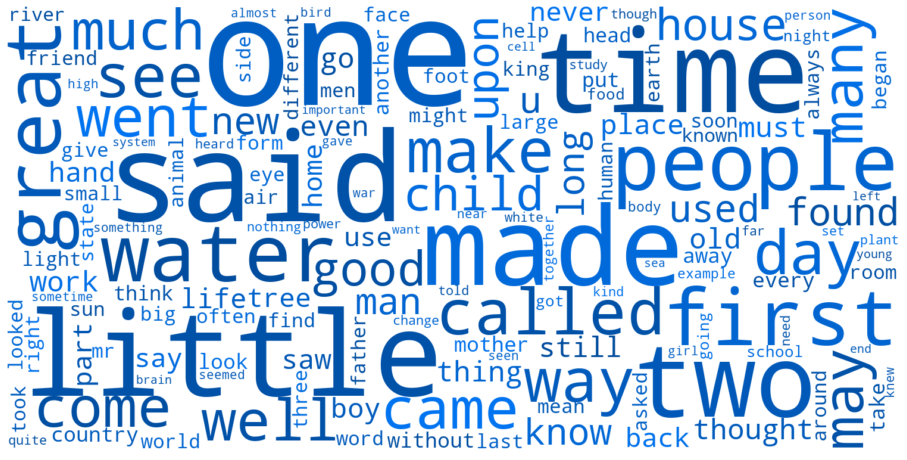

In [17]:
# color function for the wordcloud
def color_wc(word=None,font_size=None,position=None, orientation=None,font_path=None, random_state=None):
    h = int(360.0 * 150.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(80, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

plt.subplots(figsize=(16,16))
wc = WordCloud(stopwords=STOPWORDS,background_color="white", contour_width=2, contour_color='blue',width=1500, height=750,color_func=color_wc,max_words=150, max_font_size=256,random_state=42)
wc.generate(' '.join(train_df['excerpt_preprocessed']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

In [18]:
text_props = train_df.copy()

def avg_word_len(df):
    df = df.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    return df

text_len = train_df['excerpt'].str.len()
text_len_pre = train_df['excerpt_preprocessed'].str.len()
avg_text = avg_word_len(train_df['excerpt'])
avg_text_pre = avg_word_len(train_df['excerpt_preprocessed'])
lexicon_count = []
lexicon_count_pre = []
sentence_count = []
for i in range(len(train_df)):
    lc = textstat.lexicon_count(train_df['excerpt'][i])
    lcp = textstat.lexicon_count(train_df['excerpt_preprocessed'][i])
    sc = textstat.sentence_count(train_df['excerpt'][i])
    lexicon_count.append(lc)
    lexicon_count_pre.append(lcp)
    sentence_count.append(sc)
    
text_props['text_len'] = text_len
text_props['text_len_pre'] = text_len_pre
text_props['lexicon_count'] = lexicon_count
text_props['lexicon_count_pre'] = lexicon_count_pre
text_props['avg_text'] = avg_text
text_props['avg_text_pre'] = avg_text_pre
text_props['sentence_count'] = sentence_count


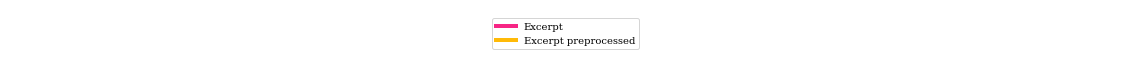

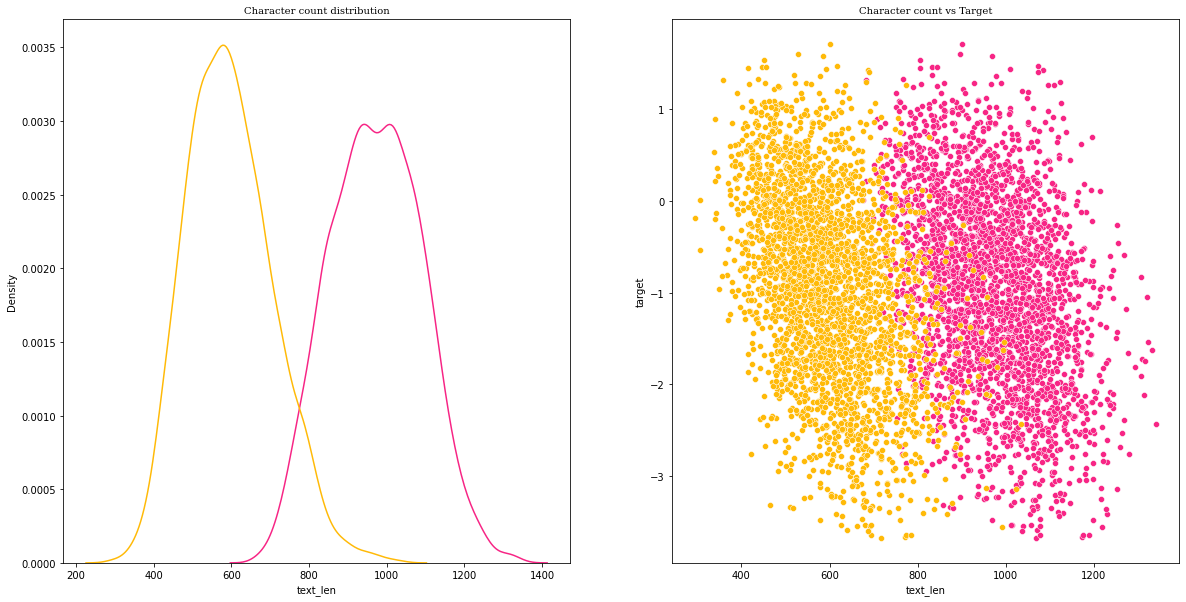

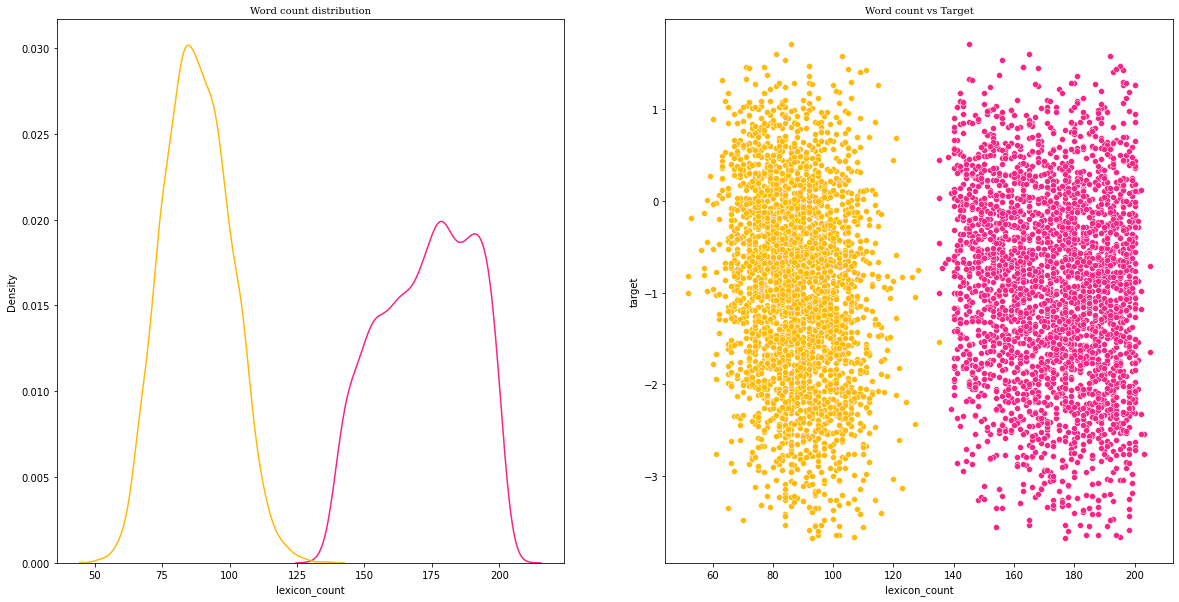

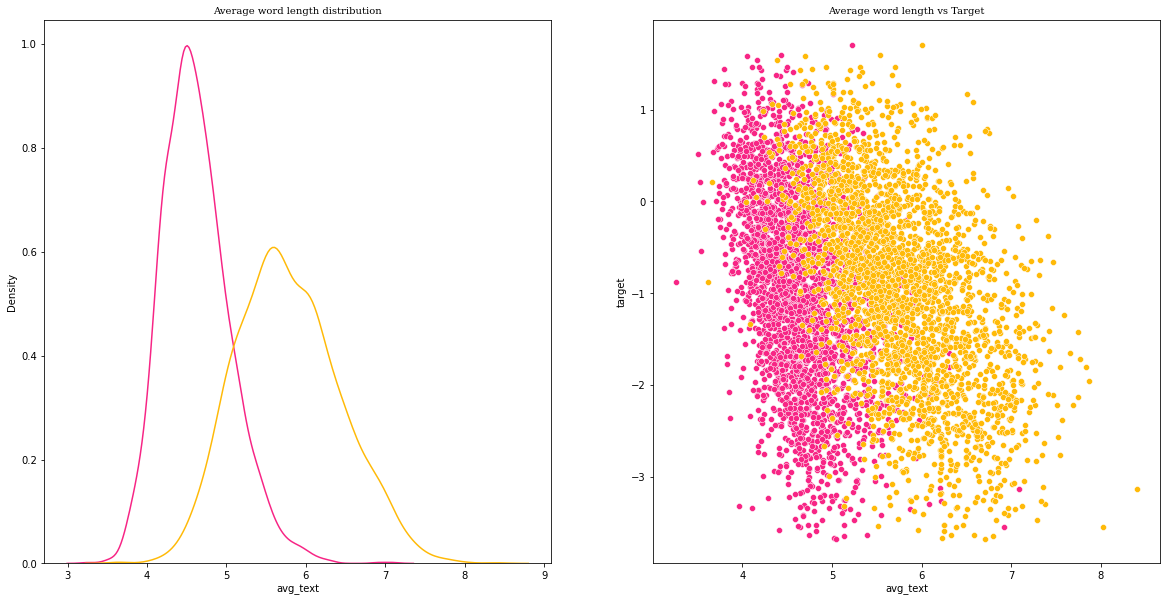

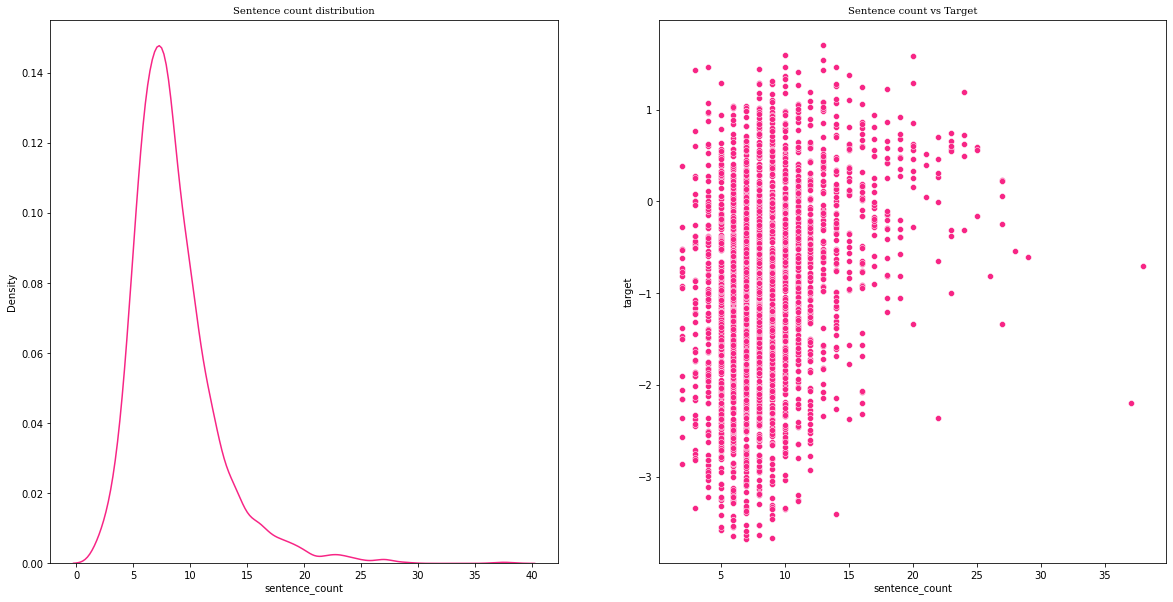

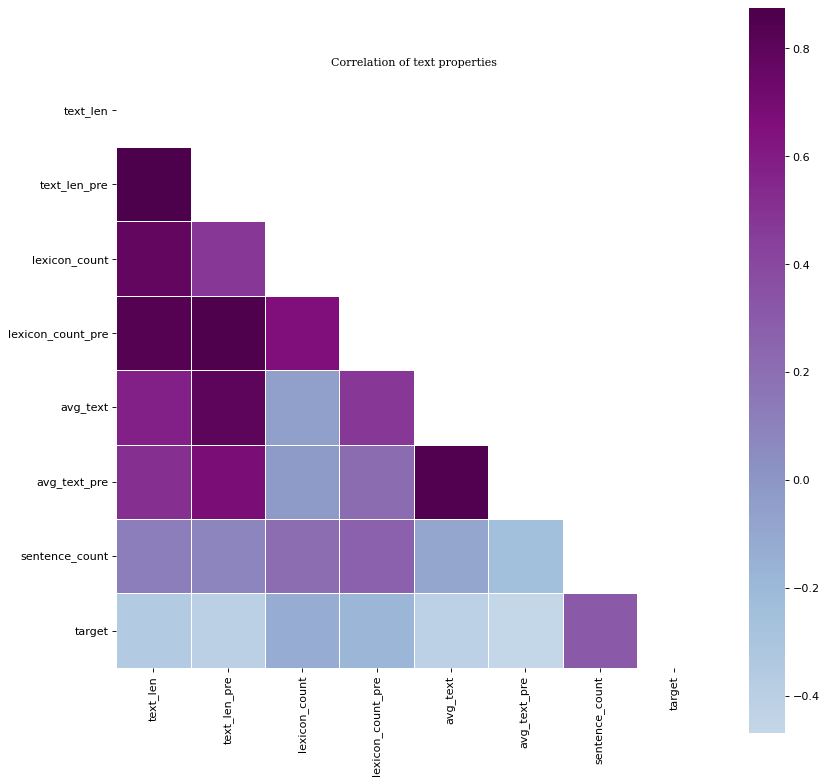

In [19]:
def plot_distribution(col1,col2,title1,title2):
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    sns.kdeplot(data=text_props, x=col1,color=palette[3],label="Excerpt",ax=ax[0])
    sns.kdeplot(data=text_props, x=col2,color=palette[4],label="Excerpt preprocessed",ax=ax[0])
    ax[0].set_title(title1,font="Serif")

    sns.scatterplot(data=text_props,x=col1,y='target',color= palette[3],ax=ax[1],markers='.')
    sns.scatterplot(data=text_props,x=col2,y='target',color= palette[4],ax=ax[1],markers='.')
    ax[1].set_title(title2,font="Serif")

    plt.show()

custom_lines = [Line2D([0], [0], color=palette[3], lw=4),
                Line2D([0], [0], color=palette[4], lw=4)]

plt.figure(figsize=(20, 1))
legend = plt.legend(custom_lines, ['Excerpt', 'Excerpt preprocessed'],loc="center")
plt.setp(legend.texts, family='Serif')
plt.axis('off')
plt.show()

plot_distribution("text_len","text_len_pre","Character count distribution","Character count vs Target")
plot_distribution("lexicon_count","lexicon_count_pre","Word count distribution","Word count vs Target")
plot_distribution("avg_text","avg_text_pre", "Average word length distribution","Average word length vs Target")

fig, ax = plt.subplots(1,2,figsize=(20,10))
sns.kdeplot(data=text_props, x=sentence_count,color=palette[3],label="Excerpt",ax=ax[0])
ax[0].set_title("Sentence count distribution",font="Serif")
ax[0].set_xlabel("sentence_count")
sns.scatterplot(data=text_props,x='sentence_count',y='target',color= palette[3],ax=ax[1],markers='.')
ax[1].set_title("Sentence count vs Target",font="Serif")
plt.show()

num_cols = ['text_len','text_len_pre','lexicon_count','lexicon_count_pre','avg_text','avg_text_pre','sentence_count','target']
corr = text_props[num_cols].corr()

fig = plt.figure(figsize=(12,12),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='BuPu', robust=True, center=0,
            square=True, linewidths=.5)
plt.title('Correlation of text properties', fontsize=15,font="Serif")
plt.show()

In [20]:
text_props['pos_tags'] = text_props['excerpt_preprocessed'].str.split().map(pos_tag)

def count_tags(pos_tags):
    tag_count = {}
    for word,tag in pos_tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return tag_count

text_props['tag_counts'] = text_props['pos_tags'].map(count_tags)

In [21]:
text_props.head(1)

,id,url_legal,license,excerpt,target,standard_error,excerpt_preprocessed,text_len,text_len_pre,lexicon_count,lexicon_count_pre,avg_text,avg_text_pre,sentence_count,pos_tags,tag_counts
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,young people returned ballroom presented decid...,992,591,179,91,4.547486,5.505495,11,"[(young, JJ), (people, NNS), (returned, VBD), ...","{'JJ': 17, 'NNS': 2, 'VBD': 7, 'RB': 6, 'VBN':..."


In [22]:
set_pos = set([tag for tags in text_props['tag_counts'] for tag in tags])
tag_cols = list(set_pos)

for tag in tqdm(tag_cols):
    text_props[tag] = text_props['tag_counts'].map(lambda x: x.get(tag, 0))

  0%|          | 0/37 [00:00<?, ?it/s]

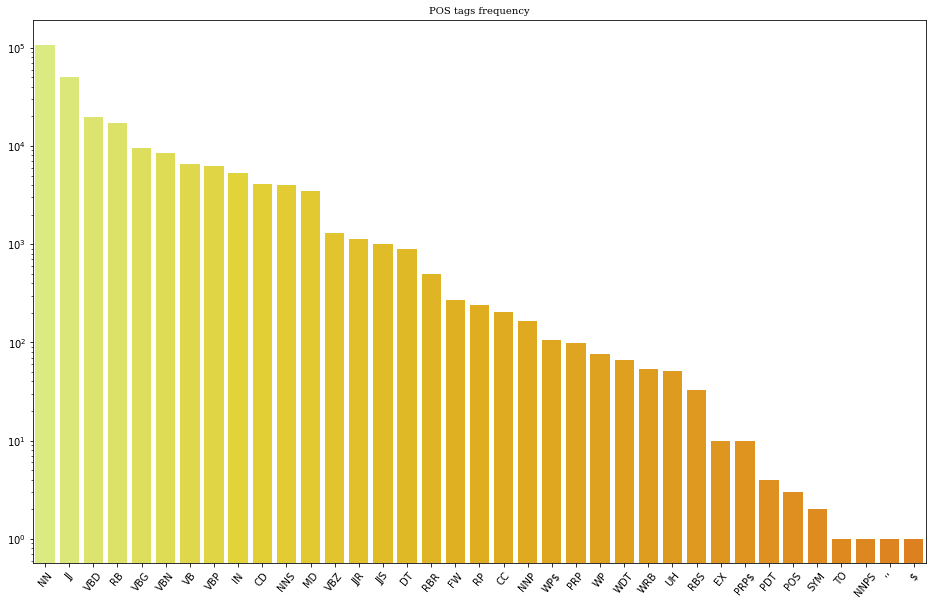

In [23]:
pos = text_props[tag_cols].sum().sort_values(ascending = False)
plt.figure(figsize=(16,10))
ax = sns.barplot(x=pos.index, y=pos.values,palette="Wistia")
plt.xticks(rotation = 50)
ax.set_yscale('log')
plt.title('POS tags frequency',fontsize=15,font="Serif")
plt.show()

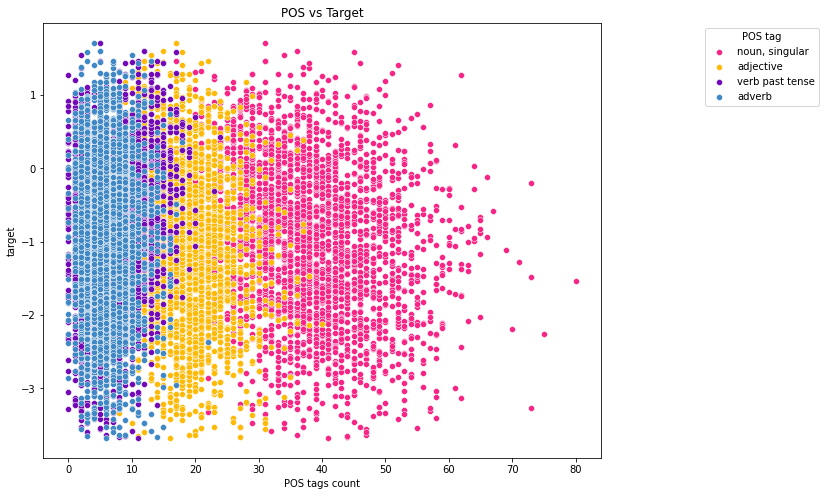

In [24]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=text_props,x='NN',y='target',color= palette[3],markers='.',label="noun, singular")
sns.scatterplot(data=text_props,x='JJ',y='target',color= palette[4],markers='.',label="adjective",)
sns.scatterplot(data=text_props,x='VBD',y='target',color= palette[0],markers='.',label="verb past tense")
sns.scatterplot(data=text_props,x='RB',y='target',color= palette[1],markers='.',label="adverb")
plt.legend(title="POS tag",bbox_to_anchor=(1.4, 1))
plt.xlabel("POS tags count")
plt.title("POS vs Target")
plt.show()

In [25]:
toughest_excerpt = text_props[text_props["target"] == text_props["target"].min()].excerpt.values[0]
lowest_target = text_props[text_props["target"] == text_props["target"].min()].target.values[0]
nlp = spacy.load("en_core_web_sm")
sentences = sent_tokenize(toughest_excerpt)
word_count = lambda sentence: len(word_tokenize(sentence))
pos_text = max(sentences, key=word_count)  

print("Target of the toughest excerpt: ")
print(lowest_target)
print("\n")
print("Longest sentence of the toughest excerpt: ")
print(pos_text)

Target of the toughest excerpt: 
-3.676267773


Longest sentence of the toughest excerpt: 
Besides this, the commutator is sustained by supports carried in flanges upon the shaft, which flanges, as an additional safeguard, are coated all over with hard rubber, one of the finest known insulators.


In [26]:
# flesch_re, flesch_kg, fog_scale, automated_r,coleman, linsear, text_standard  = ([] for i in range(7))
# for i in tqdm(range(len(text_props))):
#     flr = textstat.flesch_reading_ease(train_df['excerpt'][i])
#     flkg = textstat.flesch_kincaid_grade(train_df['excerpt'][i])
#     fs = textstat.gunning_fog(train_df['excerpt'][i])
#     ar = textstat.automated_readability_index(train_df['excerpt'][i])
#     cole = textstat.coleman_liau_index(train_df['excerpt'][i])
#     lins = textstat.linsear_write_formula(train_df['excerpt'][i])
#     ts = textstat.text_standard(train_df['excerpt'][i])
    
#     flesch_re.append(flr)
#     flesch_kg.append(flkg)
#     fog_scale.append(fs)
#     automated_r.append(ar)
#     coleman.append(cole)
#     linsear.append(lins)
#     text_standard.append(ts)
    
# text_props['flesch_re'] = flesch_re
# text_props['flesch_kg'] = flesch_kg
# text_props['fog_scale'] = fog_scale
# text_props['automated_r'] = automated_r
# text_props['coleman'] = coleman
# text_props['linsear'] = linsear
# text_props['text_standard'] = text_standard

In [27]:
# readability_cols = ['flesch_re','flesch_kg','fog_scale','automated_r','coleman','linsear','text_standard','target']

# corr = text_props[readability_cols].corr()
# fig = plt.figure(figsize=(12,12),dpi=80)
# mask = np.triu(np.ones_like(corr, dtype=bool))
# sns.heatmap(corr, mask=mask, cmap='PuBuGn', robust=True, center=0,
#             square=True, linewidths=.5,annot=True)
# plt.title('Correlation of readability tests', fontsize=15,font="Serif")
# plt.show()

In [28]:
# plt.figure(figsize=(10,8))
# sns.kdeplot(text_props["flesch_re"],color=palette[4],shade=True)
# plt.title("Distribution of Flesch Reading Ease test")
# plt.show()

In [29]:
# text_props.loc[text_props['flesch_re'] > 60]['flesch_re'].count() / len(text_props) *100


In [30]:
# pd.set_option('display.max_colwidth', None)
# max_text = text_props[text_props["target"] == text_props["target"].max()]['excerpt']
# min_text = text_props[text_props["target"] == text_props["target"].min()]['excerpt']

# max_text_f = text_props[text_props["flesch_re"] == text_props["flesch_re"].max()]['excerpt']
# min_text_f = text_props[text_props["flesch_re"] == text_props["flesch_re"].min()]['excerpt']

# print("Highest Target")
# print(max_text)
# text_props[text_props["target"] == text_props["target"].max()][['flesch_re','target','text_standard']]

In [31]:
# print("Highest Flesch Reading Ease Score")
# print(max_text_f)
# text_props[text_props["flesch_re"] == text_props["flesch_re"].max()][['flesch_re','target','text_standard']]

In [32]:
# print("Lowest Target")
# print(min_text)
# text_props[text_props["target"] == text_props["target"].min()][['flesch_re','target','text_standard']]

In [33]:
# print("Lowest Flesch Reading Ease Score")
# print(min_text_f)
# text_props[text_props["flesch_re"] == text_props["flesch_re"].min()][['flesch_re','target','text_standard']]

In [34]:
# def training(model, X_train, y_train, X_test, y_test, model_name):
#     t1 = time.time()
    
#     model = make_pipeline(
#         TfidfVectorizer(binary=True, ngram_range=(1,1)),
#         model,
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     MSE_val = mse(y_test, y_pred)
#     y_train_pred = model.predict(X_train)
#     MSE_train = mse(y_train,y_train_pred)
    
#     t2 = time.time()
#     training_time = t2-t1 
    
#     print("--- Model:", model_name,"---")
#     print("MSE train: ",MSE_train)
#     print("MSE val: ",MSE_val)
#     print("Training time:",training_time)

# ridge = Ridge(fit_intercept = True, normalize = False)
# lr = LinearRegression()
# m = [ridge,lr]
# mn = ["Ridge Regression","Linear Regression"]

X = train_df["excerpt_preprocessed"]
y = train_df['target']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# for i in tqdm(range(0,len(m))):
#     training(model=m[i], X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test, model_name=mn[i])

In [35]:
def training_all(model,X,y):
    
    model = make_pipeline(
        TfidfVectorizer(binary=True, ngram_range=(1,1)),
        model,
    )
    model.fit(X, y)
    y_pred = model.predict(test_df["excerpt_preprocessed"])
    
    return y_pred

In [36]:
ridge = Ridge(alpha=0.71, fit_intercept = True)


In [37]:
test_pred = training_all(ridge,X,y)
predictions = pd.DataFrame()
predictions['id'] = test_df['id']
predictions['target'] = test_pred
predictions.to_csv("submission.csv", index=False)
predictions

,id,target
0,c0f722661,-1.223003
1,f0953f0a5,-0.509214
2,0df072751,-0.787675
3,04caf4e0c,-2.010196
4,0e63f8bea,-1.517299
5,12537fe78,-0.495702
6,965e592c0,-0.033846


In [38]:

# print('All errors are MSE')
# print('-'*76)
# for alpha in alphas:
#     # instantiate and fit model
#     ridge = Ridge(alpha=alpha, fit_intercept=True, random_state=99)
#     ridge.fit(X_train, y_train)
#     # calculate errors
#     new_train_error = mse(y_train, ridge.predict(X_train))
#     new_validation_error = mse(y_validation, ridge.predict(X_validation))
#     # print errors as report
#     print('alpha: {:7} | train error: {:5} | val error: {:6} '.
#           format(alpha,
#                  round(new_train_error,3),
#                  round(new_validation_error,3)))

In [39]:
# # alphas = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 10]
# alphas = [0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75]

# def training(model, X_train, y_train, X_test, y_test, model_name,alpha):
#     t1 = time.time()
    
#     model = make_pipeline(
#         TfidfVectorizer(binary=True, ngram_range=(1,1)),
#         model,
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     MSE_val = mse(y_test, y_pred)
#     y_train_pred = model.predict(X_train)
#     MSE_train = mse(y_train,y_train_pred)
    
#     t2 = time.time()
#     training_time = t2-t1 
    
#     print("--- Model:", model_name,"---")
#     print("Alpha : ",alpha)
#     print("MSE train: ",MSE_train)
#     print("MSE val: ",MSE_val)
#     print("Training time:",training_time)
#     return alpha,MSE_val,model_name


# X = train_df["excerpt_preprocessed"]
# y = train_df['target']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# current_mse=100
# current_alpha=0
# for j in alphas:
#     ridge = Ridge(alpha=j,fit_intercept = True)
#     lr = LinearRegression()
#     m = [ridge]
#     mn = ["Ridge Regression"]

#     for i in tqdm(range(0,len(m))):
#             alpha,MSE_val,model_name = training(model=m[i], X_train=X_train, y_train=y_train, X_test=X_test,y_test=y_test, model_name=mn[i],alpha=j)
#             if model_name=="Ridge Regression":
#                 if MSE_val<current_mse:
#                     current_mse=MSE_val
#                     current_alpha=alpha
# print("Model best Params:")
# print(f"MSE:{current_mse}")
# print(f"Alpha:{current_alpha}")